In [1]:
from google.colab import auth
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cv2 as cv
import subprocess
import itertools
from tqdm import tqdm
import os
import numba as nb
plt.style.use("seaborn-v0_8-white")

auth.authenticate_user()

In [2]:
!mkdir false_color
!gsutil cp gs://india_field_delineation/predictions/watershed_instances_4096px/india_00/india_00040.npy /content/watershed0.npy
!gsutil cp gs://india_field_delineation/predictions/boundary_predictions_4096px_averaged/india_00/india_00040.png /content/boundary.png
!gsutil cp gs://india_field_delineation/predictions/extent_predictions_4096px_averaged/india_00/india_00040.png /content/extent.png
#!gsutil cp gs://india_field_delineation/airbus_false_color/2020-2021/256px/india_00/india_00040_0/india_00040_0_x0000_y0000.png /content/falsecolor.npy

Copying gs://india_field_delineation/predictions/watershed_instances_4096px/india_00/india_00040.npy...
| [1 files][128.0 MiB/128.0 MiB]                                                
Operation completed over 1 objects/128.0 MiB.                                    
Copying gs://india_field_delineation/predictions/boundary_predictions_4096px_averaged/india_00/india_00040.png...
- [1 files][  7.0 MiB/  7.0 MiB]                                                
Operation completed over 1 objects/7.0 MiB.                                      
Copying gs://india_field_delineation/predictions/extent_predictions_4096px_averaged/india_00/india_00040.png...
- [1 files][  7.5 MiB/  7.5 MiB]                                                
Operation completed over 1 objects/7.5 MiB.                                      


In [3]:
#pixel_range = np.arange(0, 4096, 256)
pixel_range = np.arange(0, 1024, 256)
print(len(pixel_range)**2)

pixel_coords = itertools.product(pixel_range, pixel_range)
for x, y in tqdm(pixel_coords):
    source = "gs://india_field_delineation/airbus_false_color/2020-2021/256px/india_00/india_00040_0/india_00040_0_x{:04}_y{:04}.png".format(x, y)
    dest = "/content/false_color/{:04}_{:04}.png".format(x, y)
    os.system(
        f"gsutil cp {source} {dest}"
    )


16


16it [00:44,  2.75s/it]


In [4]:
pixels = len(pixel_range) * 256
false_color_t = np.empty((pixels, pixels, 3), dtype=np.uint8)
for i, x in enumerate(pixel_range):
    for j, y in enumerate(pixel_range):
        tile = cv.imread("/content/false_color/{:04}_{:04}.png".format(x, y))
        false_color_t[i*256:(i+1)*256, j*256:(j+1)*256, :] = tile

watershed0_t = np.load("/content/watershed0.npy", allow_pickle=False)
boundary_t = cv.imread("/content/boundary.png", cv.IMREAD_GRAYSCALE)
extent_t = cv.imread("/content/extent.png", cv.IMREAD_GRAYSCALE)

In [ ]:
MIN_FIELD_SIZE = 0
counts = np.unique(watershed0_t, return_counts=True)
watershed0_t[np.isin(watershed0_t, counts[0][counts[1] < MIN_FIELD_SIZE])] = -1

In [ ]:
sl = slice(0, 1024), slice(0, 1024)
watershed0 = watershed0_t[sl]
boundary = boundary_t[sl]
extent = extent_t[sl]
false_color = false_color_t[sl]

In [ ]:

def draw_segmentation(img, mapping=None, ax=None):
    if mapping is None:
        draw_img = img
        field_id_mapping = None
    else:
        if mapping == "random":
            field_idxs = np.unique(img)
            np.random.shuffle(field_idxs)
            field_id_mapping = {field_id: i for i,
                            field_id in enumerate(field_idxs)}
        else:
            field_id_mapping = mapping
        draw_img = np.vectorize(field_id_mapping.get)(img)
        draw_img[draw_img == None] = 0
        draw_img = draw_img.astype(np.int64)
        draw_img[img<2] = 0#img[img<2]

    cmap = plt.get_cmap('nipy_spectral', np.max(draw_img))
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(draw_img, cmap="nipy_spectral", interpolation="none")
    return field_id_mapping


'\nfig, axs = plt.subplots(1, 3, figsize=(16, 5))\naxs[0].imshow(false_color)\naxs[1].imshow(boundary, cmap="viridis")\ndraw_segmentation(watershed0, axs[2])\n'

## Open CV Watershed

In [ ]:
def segment_watershed(boundary, extent):
    ret, thresh = cv.threshold(extent, 0, 255, cv.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    # Finding sure background area
    sure_bg = 255-cv.dilate(thresh, kernel, iterations=2)
    # Finding sure foreground area
    dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(255-sure_fg, sure_bg)
    ret, markers = cv.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown == 255] = 0
    boundary_threechannel = cv.cvtColor(boundary, cv.COLOR_GRAY2BGR)
    watershed = markers.copy()
    cv.watershed(boundary_threechannel, watershed)
    return watershed

In [ ]:
ret, thresh = cv.threshold(extent, 0, 255, cv.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
# Finding sure background area
sure_bg = 255-cv.dilate(thresh, kernel, iterations=2)
# Finding sure foreground area
dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(255-sure_fg, sure_bg)
ret, markers = cv.connectedComponents(sure_fg)
markers = markers+1
markers[unknown == 255] = 0
boundary_threechannel = cv.cvtColor(boundary, cv.COLOR_GRAY2BGR)
watershed1 = markers.copy()
cv.watershed(boundary_threechannel, watershed1)
pass

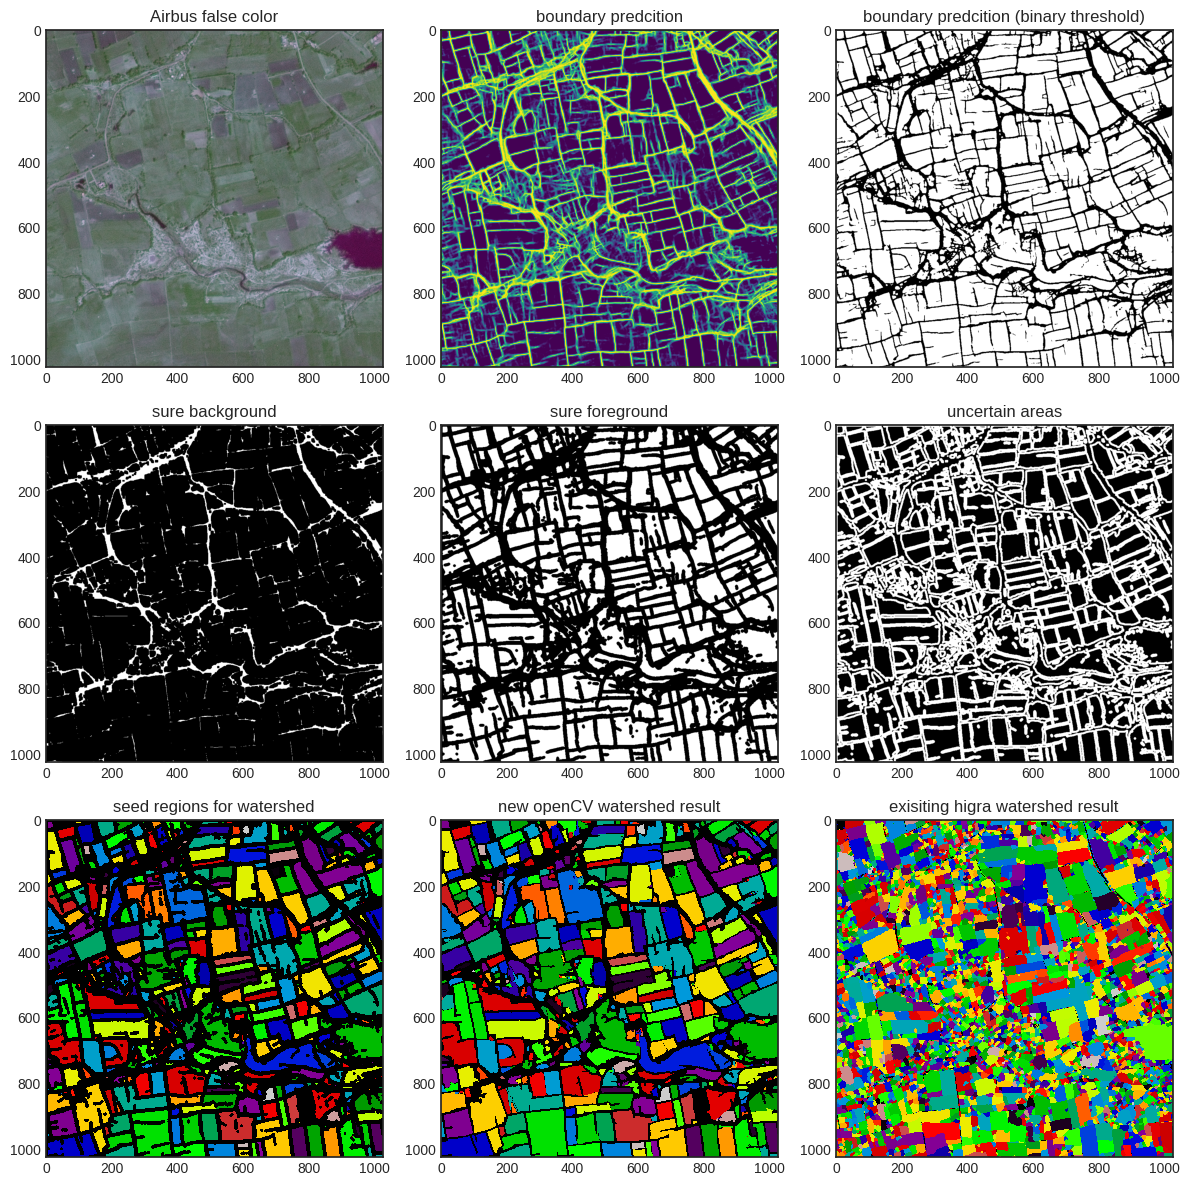

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[0][0].imshow(false_color)
axs[0][1].imshow(boundary, cmap="viridis")
axs[0][2].imshow(thresh, cmap="gray")
axs[1][0].imshow(sure_bg, cmap="gray")
axs[1][1].imshow(sure_fg, cmap="gray")
axs[1][2].imshow(unknown, cmap="gray")
mapping = draw_segmentation(markers, "random", axs[2][0])
draw_segmentation(watershed1, mapping, axs[2][1])
draw_segmentation(watershed0, "random", axs[2][2])

title = [
    "Airbus false color",
    "boundary predcition",
    "boundary predcition (binary threshold)",
    "sure background",
    "sure foreground",
    "uncertain areas",
    "seed regions for watershed",
    "new openCV watershed result",
    "exisiting higra watershed result",
]
for ii, (i, j) in enumerate(itertools.product(range(3), range(3))):
    if ii < len(title):
        axs[i][j].set_title(title[ii])
    #axs[i][j].axis("off")

fig.tight_layout()

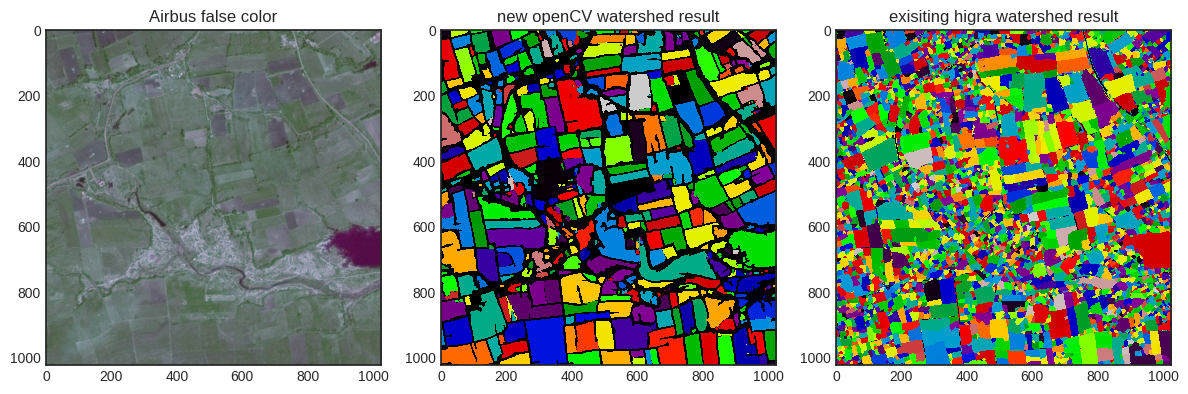

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(false_color)
#axs[0][1].imshow(boundary, cmap="viridis")
#axs[0][2].imshow(thresh, cmap="gray")
#axs[1][0].imshow(sure_bg, cmap="gray")
#axs[1][1].imshow(sure_fg, cmap="gray")
#axs[1][2].imshow(unknown, cmap="gray")
#mapping = draw_segmentation(markers, "random", axs[2][0])
draw_segmentation(watershed1, "random", axs[1])
draw_segmentation(watershed0, "random", axs[2])

title = [
    "Airbus false color",
    #"boundary predcition",
    #"boundary predcition (binary threshold)",
    #"sure background",
    #"sure foreground",
    #"uncertain areas",
    #"seed regions for watershed",
    "new openCV watershed result",
    "exisiting higra watershed result",
]
for ii, (i, j) in enumerate(itertools.product(range(3), range(3))):
    if ii < len(title):
        axs[j].set_title(title[ii])
    #axs[i][j].axis("off")

fig.tight_layout()
fig.savefig("/content/watershed1.png", dpi=300)

Text(0, 0.5, '# of fields (in 1024x1024 region)')

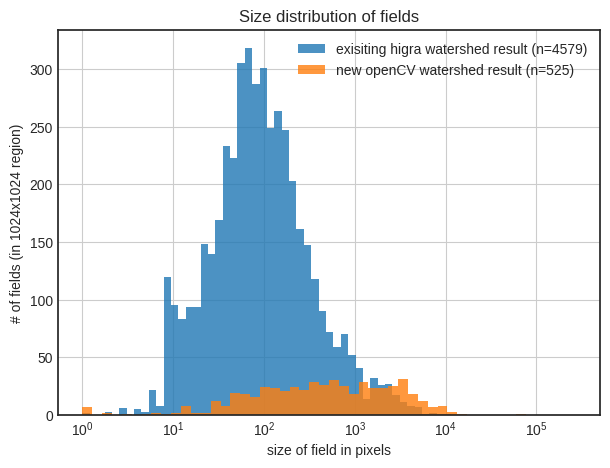

In [ ]:
def plot_size_distribution(watershed_res, title, ax=None):
    counts = np.unique(watershed_res, return_counts=True)[1]
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.set_xscale('log')
    hist, bins = np.histogram(counts, bins=50)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    ax.hist(counts, bins=logbins, density=False, label=title, alpha=0.8)
    ax.grid(True)
    #ax.set_xlim(0, 1e3)
    #ax.set_title(title)

fig, ax = plt.subplots(1, figsize=(7, 5))
plot_size_distribution(watershed0, f"exisiting higra watershed result (n={len(np.unique(watershed0))})", ax)

plot_size_distribution(watershed1, f"new openCV watershed result (n={len(np.unique(watershed1))})", ax)
ax.legend()
ax.set_title("Size distribution of fields")
ax.set_xlabel("size of field in pixels")
ax.set_ylabel("# of fields (in 1024x1024 region)")

